# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d25/9bb07a5e09b09da62cd27426972a16f29a246bec415aa14abce9e3a1.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Moscow, Moscow, Russia**, and the stations the data comes from are shown on the map below.

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(25,'9bb07a5e09b09da62cd27426972a16f29a246bec415aa14abce9e3a1')

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


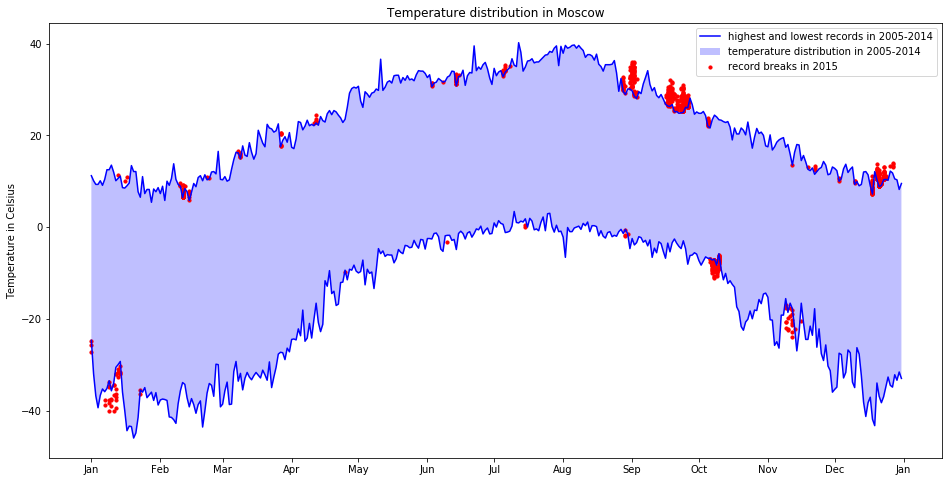

In [123]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import re

def get_min_max(all_df):
    
    def create_dates(begin, end):
        dates = np.arange(begin, end, dtype='datetime64[D]')
        regex = re.compile(r'\d{4}-02-29')
        return list(filter(lambda date: not regex.match(date), map(lambda date: date.__str__(), dates)))
    
    ten_years_df = all_df.loc[create_dates('2005', '2015')]
    min_max_df = pd.DataFrame(index=create_dates('2015', '2016'), columns=['min', 'max'])
   
    def fill_min_max(row):
        day = re.sub(r'.*(\d{2}-\d{2}$)', r'\1', row.name)
        day_df = ten_years_df[ten_years_df.index.str.match(r'.*{}$'.format(day))]
        row['min'] = day_df[day_df['Element'] == 'TMIN']['Data_Value'].min()
        row['max'] = day_df[day_df['Element'] == 'TMAX']['Data_Value'].max()
        return row
    
    min_max_df = min_max_df.apply(fill_min_max, axis=1)
    return min_max_df

def get_year_fluctuations(all_df, min_max_df):
    year_df = all_df[all_df.index.str.match(r'2015.*')]
    
    def fill_fluctuations(row):
        min_val = min_max_df.loc[row.name]['min']
        max_val = min_max_df.loc[row.name]['max']
        val = row.Data_Value
        return val if val > max_val or val < min_val else None
    
    fluctuations = year_df.apply(fill_fluctuations, axis=1)
    fluctuations = pd.DataFrame(fluctuations)
    fluctuations.columns = ['Data_Value',]
    
    return fluctuations
        

def draw(min_max_df, fluctuations):    
    plt.figure(figsize=(16,8))
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.ylabel('Temperature in Celsius')
    plt.title('Temperature distribution in Moscow')
    
    min_max_df.index = map(pd.to_datetime, min_max_df.index)
    plt.plot(min_max_df['min'], '-', c='blue', label='_')
    plt.plot(min_max_df['max'], '-', c='blue', label='highest and lowest records in 2005-2014')
    
    ax.fill_between(min_max_df.index, min_max_df['min'], min_max_df['max'], facecolor='blue', alpha=0.25,
                   label='temperature distribution in 2005-2014')
    
    fluctuations.index = map(pd.to_datetime, fluctuations.index)
    plt.scatter(fluctuations.index, fluctuations['Data_Value'], c='red', s=10, label='record breaks in 2015')
    
    ax.legend()
    plt.savefig('weather.png')

def weather_statistics_plot(hash_val):
    all_df = pd.read_csv('data/C2A2_data/BinnedCsvs_d25/{}.csv'.format(hash_val), index_col=1)
    all_df['Data_Value'] = all_df.apply(lambda row: row['Data_Value'] / 10, axis=1)
    
    min_max_df = get_min_max(all_df)
    fluctuations = get_year_fluctuations(all_df, min_max_df)
    draw(min_max_df, fluctuations)
    
weather_statistics_plot('9bb07a5e09b09da62cd27426972a16f29a246bec415aa14abce9e3a1')